## Top 20 corrélations avec les acouphènes

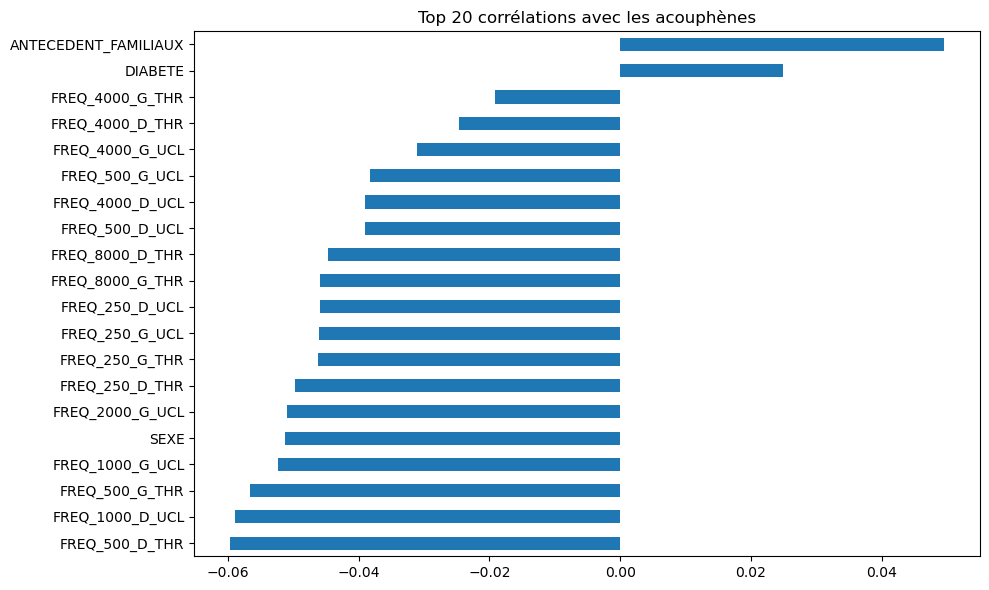

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("df_final.csv", sep=";", low_memory=False)
df["ACOUPHENES"] = df["ACOUPHENES"].map({"Oui": 1, "Non": 0})

# Encodage basique des catégorielles
for col in df.select_dtypes(include="object").columns:
    if col != "ID_CLIENT":
        df[col] = df[col].astype(str).factorize()[0]

# Corrélation
cor_matrix = df.corr(numeric_only=True)
corr_with_target = cor_matrix["ACOUPHENES"].drop("ACOUPHENES").sort_values(ascending=False)

# Top 20
top_corr = corr_with_target.head(20)

plt.figure(figsize=(10, 6))
top_corr.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 corrélations avec les acouphènes")
plt.tight_layout()
plt.show()


On constate que les variables les plus positivement corrélées aux acouphènes sont les antécédents familiaux et le diabète, bien que les corrélations restent faibles. La majorité des autres variables, notamment les seuils auditifs à différentes fréquences, présentent une légère corrélation négative avec les acouphènes. Le tout reste bien faible malgré tout.

---

## Écart moyen avec vs sans acouphènes

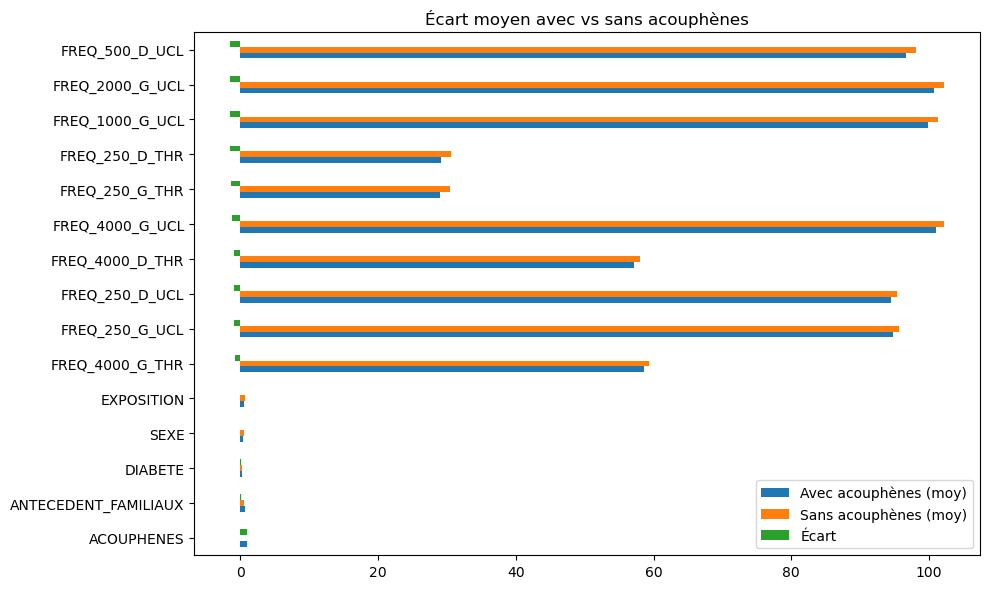

In [2]:
# Séparation des groupes
with_ac = df[df["ACOUPHENES"] == 1]
without_ac = df[df["ACOUPHENES"] == 0]

# Comparaison
summary = pd.DataFrame({
    "Avec acouphènes (moy)": with_ac.mean(numeric_only=True),
    "Sans acouphènes (moy)": without_ac.mean(numeric_only=True),
    "Écart": with_ac.mean(numeric_only=True) - without_ac.mean(numeric_only=True)
}).sort_values("Écart", ascending=False)

# Affichage des top 15
summary.head(15).plot(kind="barh", figsize=(10,6), title="Écart moyen avec vs sans acouphènes")
plt.tight_layout()
plt.show()


Ce code basé sur la moyenne de chaque feature à la différence de Accouphènes ou pas Accouphènes nous permet d'observer que les personnes souffrant d’acouphènes présentent en moyenne des seuils auditifs légèrement plus bas à certaines fréquences par rapport à celles qui n’en ont pas, bien que les écarts restent faibles. Les différences sont principalement observées sur les mesures auditives, tandis que les variables comme le sexe, le diabète ou les antécédents familiaux montrent peu d’écart moyen. Néanmoins on se rend bien compte que l'on ne peut pas en tirer grand chose, même en augmentant les écarts (logarithme etc..) tellement tout est proche.

---

## Corrélation entre âge et seuil auditif

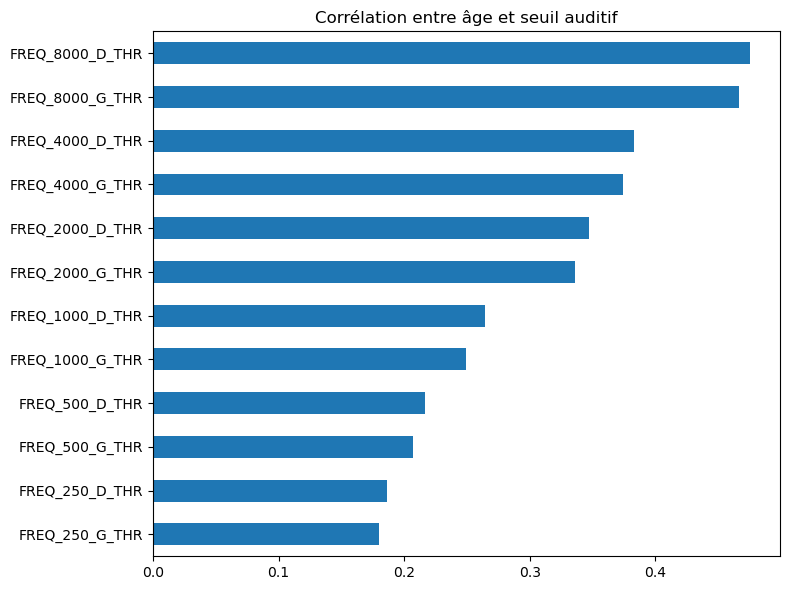

In [3]:
freq_cols = [col for col in df.columns if "_THR" in col and "FREQ" in col]

age_corrs = df[freq_cols + ["AGE"]].corr()["AGE"].drop("AGE").sort_values()

plt.figure(figsize=(8, 6))
age_corrs.plot(kind="barh")
plt.title("Corrélation entre âge et seuil auditif")
plt.tight_layout()
plt.show()


Le graphique montre que l’âge est positivement corrélé aux seuils auditifs, surtout aux hautes fréquences (8000 Hz, 4000 Hz), ce qui suggère une perte auditive liée à l’âge. Le code calcule la corrélation entre l’âge et chaque seuil auditif (variables contenant _THR) et affiche les résultats triés sous forme de barres horizontales.

---

## Asymétrie auditive (droite vs gauche)

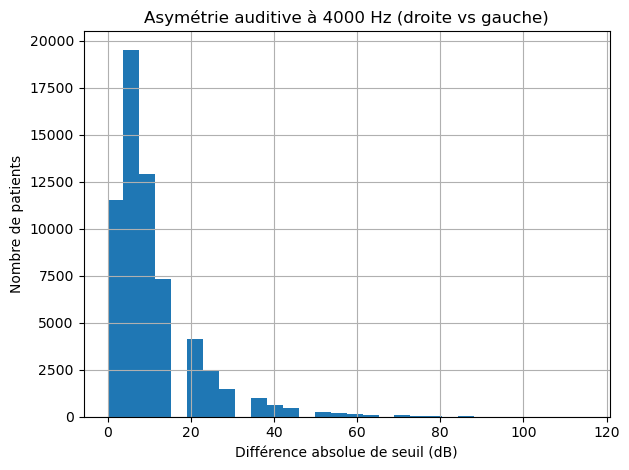

In [4]:
# Exemple sur 4000 Hz
df["ASYM_4000_THR"] = abs(df["FREQ_4000_D_THR"] - df["FREQ_4000_G_THR"])
df["ASYM_4000_THR"].hist(bins=30)
plt.title("Asymétrie auditive à 4000 Hz (droite vs gauche)")
plt.xlabel("Différence absolue de seuil (dB)")
plt.ylabel("Nombre de patients")
plt.tight_layout()
plt.show()


On constate que la majorité des patients présentent une faible asymétrie auditive entre l’oreille droite et gauche à 4000 Hz, avec une différence de seuil inférieure à 10 dB. Une asymétrie marquée (supérieure à 20 dB) est beaucoup plus rare, mais présente chez une minorité. Cette observation est transposable à chaque fréquence que ce soit pour THR ou UCL.

---

## Pourcentage de personnes testées ayant des accouphènes par tranche d'âge

In [6]:
resultats = []

# Boucle par tranche d'âge de 0 à 120 ans
for age_min in range(0, 121, 5):
    age_max = age_min + 5
    tranche = df[(df["AGE"] >= age_min) & (df["AGE"] < age_max)]
    total = len(tranche)
    acouphene = len(tranche[tranche["ACOUPHENES"] == 1])
    pourcentage = (acouphene / total * 100) if total > 0 else 0
    resultats.append({
        "Tranche d'âge": f"{age_min}-{age_max - 1}",
        "Pourcentage acouphènes": round(pourcentage, 2),
        "Nombre total": total
    })


df_resultats = pd.DataFrame(resultats)
display(df_resultats)


,Tranche d'âge,Pourcentage acouphènes,Nombre total
0,0-4,50.00,22
1,5-9,0.00,8
2,10-14,36.36,22
3,15-19,50.00,102
4,20-24,54.31,197
5,25-29,52.69,279
6,30-34,56.93,397
7,35-39,55.93,565
8,40-44,58.62,795
9,45-49,59.77,1290


Le pourcentage de patients rapportant des acouphènes augmente progressivement à partir de l’adolescence, atteint un pic autour de 45-59 ans (~58 %), puis diminue avec l’âge avancé. Très peu de cas sont enregistrés avant 15 ans ou après 95 ans, en raison d’un faible effectif dans ces tranches. Cela nous montre bien que les jeunes qui vont se faire tester le font probablement car ils ressentent une douleur déjà, contrairement aux personnes agées qui elles le font plus au cas où.